In [21]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cftime
import scipy.signal as sp
import matplotlib.patches as mtp

In [22]:
#Función de Pedro para quitar la tendencia en todos los ptos.
def xarray_trend(xarr):    
    from scipy import stats
    # getting shapes
    
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]

    
    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    # misclaneous additional functions
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5
    
    # preparing outputs
    out = xarr[:2].mean('time')

    # 
    xarr_inter = out.copy()
    xarr_inter.name += '_intercept'
    xarr_inter.attrs['units'] = ''
    xarr_inter.values = intercept.reshape(xarr.shape[1:])
    
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = 'units / day'
    xarr_slope.values = slope.reshape(xarr.shape[1:])

    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])

    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p
    xarr_out['intercept'] = xarr_inter
        

    return xarr_out

In [23]:
#Funciones del curso de la universidad de Hawaii para hacer el análisis espectral (frecuencia, ps y psd).
#Están adaptadas para usarlas con los DataArray de 3 dimensiones.

def spectrum1(h, dt=7):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h, axis=0)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

def spectrum2(h, dt=7, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weight = np.ones(nsmooth, dtype=float) / nsmooth
    weights = np.ones((nsmooth, 1, 1), dtype=float) / nsmooth
    freqs_s = sp.fftconvolve(freqs, weight, mode='valid')
    
    ps_s = sp.fftconvolve(ps, weights, mode='valid')
    psd_s = sp.fftconvolve(psd, weights, mode='valid')
    
    return freqs_s, ps_s, psd_s
    
def spectrum2p(h, dt=1, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s
        
#Ya se hizo el detrend a los datos.
"""
def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
"""
 
def quadwin(n):
    """
    Qu32*80ow
    """
    t = np.arange(n)
    winp = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    win = np.expand_dims(np.expand_dims(winp, 1), 1)
    return win

def spectrum4(h, dt=7, nsmooth=5):
    """
    Detrend and apply a quadratic window.
    """
    n = len(h)

    #h_detrended = detrend(h)
    
    winweights = quadwin(n)
    #h_win = h_detrended * winweights
    h_win = h * winweights
    
    freqs, ps, psd = spectrum2(h_win, dt=dt, nsmooth=nsmooth)
    
    # Compensate for the energy suppressed by the window.
    psd *= n / (winweights**2).sum()
    ps *= n**2 / winweights.sum()**2
    
    return freqs, ps, psd

In [24]:
#Ruta al acceso directo en mi drive igual que la ruta del archivo original en el drive de Pedro.
data = xr.open_dataset('./Data/sla_NorthPacific7D.nc')

#Se multiplica por 100 para que las unidades coincidan con las de Koyashi, centímetros.
data *= 100

In [25]:
data.sla

<xarray.DataArray 'sla' (time: 1409, latitude: 240, longitude: 560)>
array([[[-0.4 , -2.1 , -3.71, ...,  5.31,  4.85,  4.36],
        [  nan, -2.81, -4.35, ...,  4.95,  4.6 ,  4.24],
        [-2.16,   nan, -5.35, ...,  3.88,  3.76,  3.67],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[-2.75, -3.39, -4.05, ...,  6.12,  6.07,  5.97],
        [  nan, -4.13, -4.55, ...,  6.56,  6.54,  6.47],
        [-4.77,   nan, -5.48, ...,  6.95,  6.99,  6.99],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[-2.16, -2.15, -2.13, ..., 11.15, 10.98, 10.62],
        [  nan, -1.96, -1.98, ..., 11.54, 11.32, 10.91],
        [-1.7 ,   nan, -2.16, ..., 11.42, 11.22, 10.84],
        ...,
...
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[ 4.69,  2.27, -0.02, ...,  8.1 ,  7.86,  7.7 ],
        [  nan,  2.96,  1.17, ...,  8.51,  8.24,  8.05],
        [ 5.09,   nan,  1.85, ...,  9.17,  8.88,  8.66],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[ 4.1 ,  3.18,  2.27, ..., 12.92, 12.47, 12.08],
        [  nan,  4.19,  3.64, ..., 13.3 , 12.9 , 12.51],
        [ 5.11,   nan,  4.76, ..., 13.74, 13.46, 13.13],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]]])
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-08 ... 2019-12-27
  * latitude   (latitude) float32 0.125 0.375 0.625 0.875 ... 59.38 59.62 59.88
  * longitude  (longitude) float32 120.1 120.4 120.6 120.9 ... 259.4 259.6 259.9

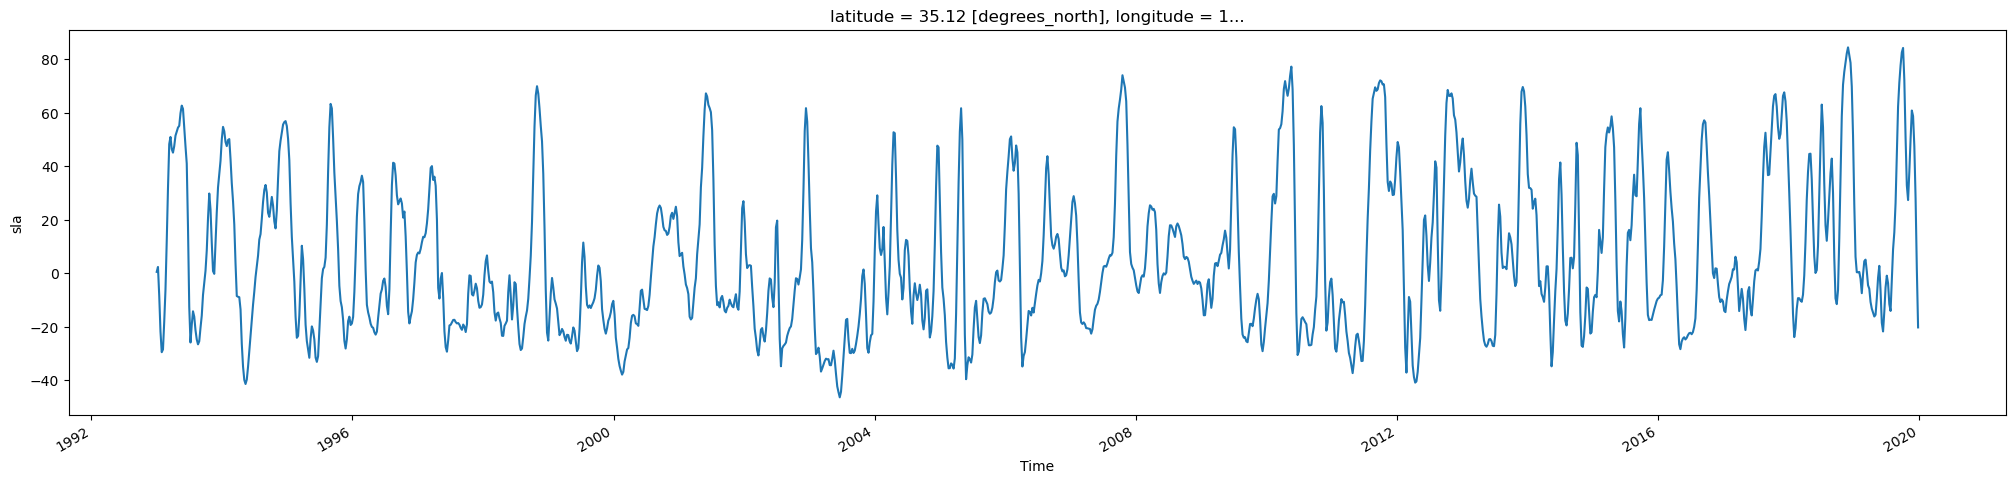

In [26]:
#Coordenadas que uso de ejemplo.
fig, ax = plt.subplots(figsize=(25, 5))
ej = data.sla.sel(latitude=35, longitude=160, method='nearest')
ej.plot()

plt.show()

In [27]:
#Quito la tendencia de los datos en el pto ejemplo con un ajuste por mínimos cuadrados.

#fig, ax = plt.subplots(figsize=(25, 5))
p = np.polyfit(np.arange(len(data.time)), ej, 1)
ej_ten = ej - np.polyval(p, np.arange(len(data.time)))
#ej_ten.plot()

#plt.show()

/var/folders/tj/cj2twzcd30jbzn574lsp6phw0000gn/T/ipykernel_47351/2324049245.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


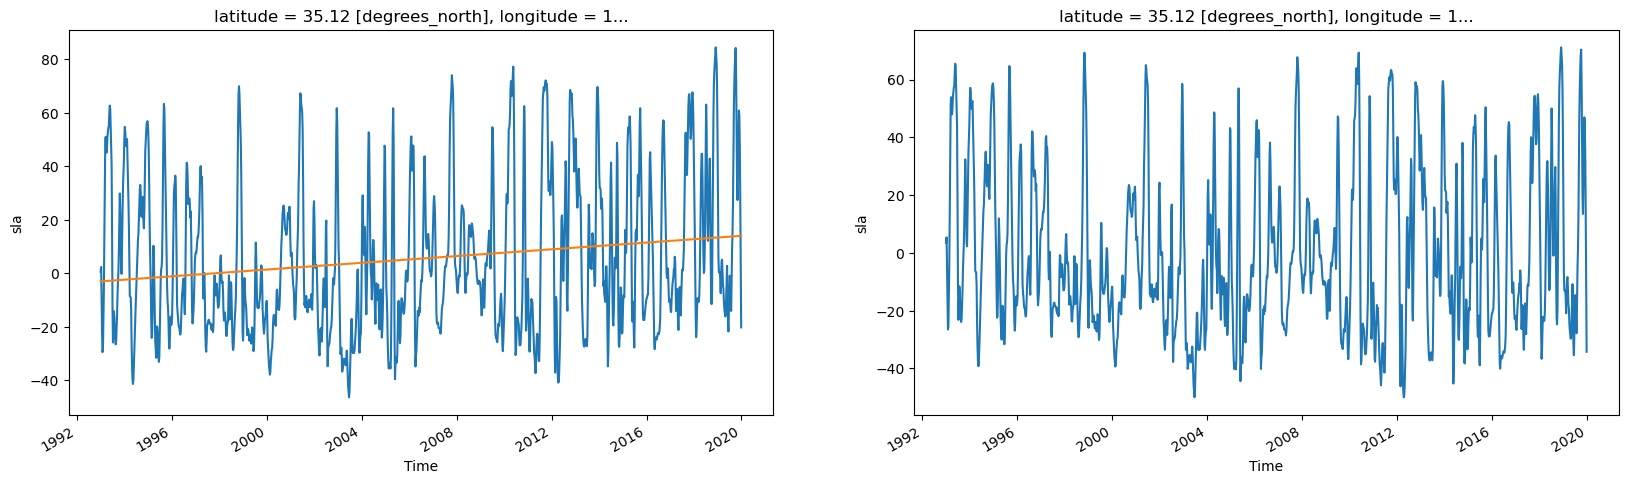

In [28]:
#Con y sin tendencia.

fig, ax = plt.subplots(figsize=(20,5))
plt.subplot(1, 2, 1)
ej.plot()
(ej - ej_ten).plot()

plt.subplot(1, 2, 2)
ej_ten.plot()


In [29]:
#Manipulaciones necesarias para quitar la tendencia del DataArray.

dt_trend = xarray_trend(data.sla)
np_Time = data.sla.time.to_pandas().index.to_julian_date().values
np_Slope = dt_trend.slope.values
np_Inter = dt_trend.intercept.values
np_Trend = np_Slope[...,None] * np_Time + np_Inter[:,:,None]
np_Trend = np.swapaxes(np.swapaxes(np_Trend,0,2),1,2)

data_dt = data.sla - np_Trend

In [30]:
#Se calcula aquí el espectro de todos los datos sin tendencia aunque se use más tarde porque si no se satura la ram del colab.

freqs_t, ps_t, psd_t = spectrum1(data_dt, dt=7)

[4.42312853e-13 6.13731288e-13 7.84705634e-13 ... 2.11386464e-13
 3.81916720e-13 5.52446977e-13]


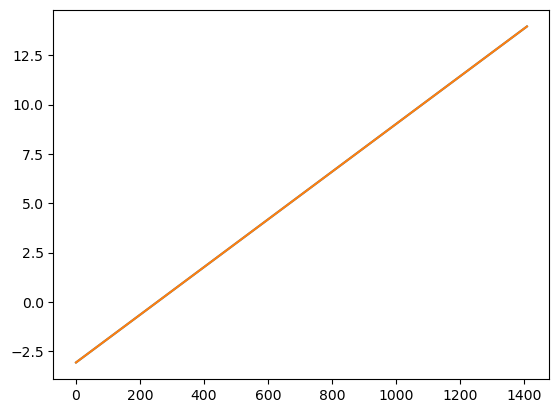

In [31]:
#Se comprueba que queda igual que en el ejemplo.
plt.plot(np_Trend[:,140,160])
plt.plot(np.polyval(p, np.arange(len(data.time))))

print(np_Trend[:,140,160] - np.polyval(p, np.arange(len(data.time))))

In [32]:
#Función para quitar la climatología y quedarnos con la anomalía.

def rm(x):
    return x - x.mean(dim='time')

#ej_anom_day = ej_ten.groupby('time.dayofyear').apply(rm)
ej_anom_month = ej_ten.groupby('time.month').apply(rm)

#data_dt_day = data_dt.groupby('time.dayofyear').apply(rm)
data_dt_month = data_dt.groupby('time.month').apply(rm)

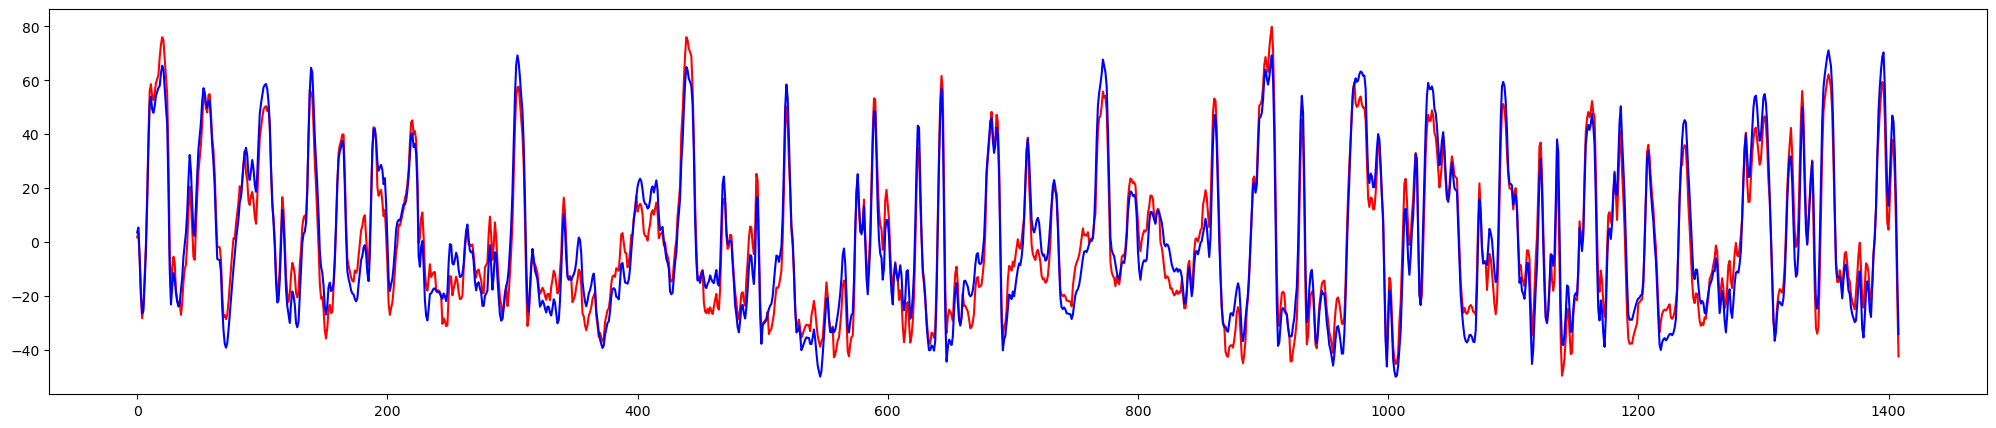

In [33]:
#Se representa la serie temporal en las coordenadas de ejemplo, sin tendencia (azul) y sin tendencia ni ciclo estacional (rojo).

fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(ej_anom_month, 'r')
plt.plot(ej_ten, 'b')

#plt.plot(ej_ten - ej_anom_month)

plt.show()

<xarray.DataArray 'sla' (time: 1409)>
array([-6.52811138e-14,  1.06137321e-13,  2.77111667e-13, ...,
       -2.64677169e-13, -9.23705556e-14,  7.10542736e-14])
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-08 ... 2019-12-27
    latitude   float32 35.12
    longitude  float32 160.1


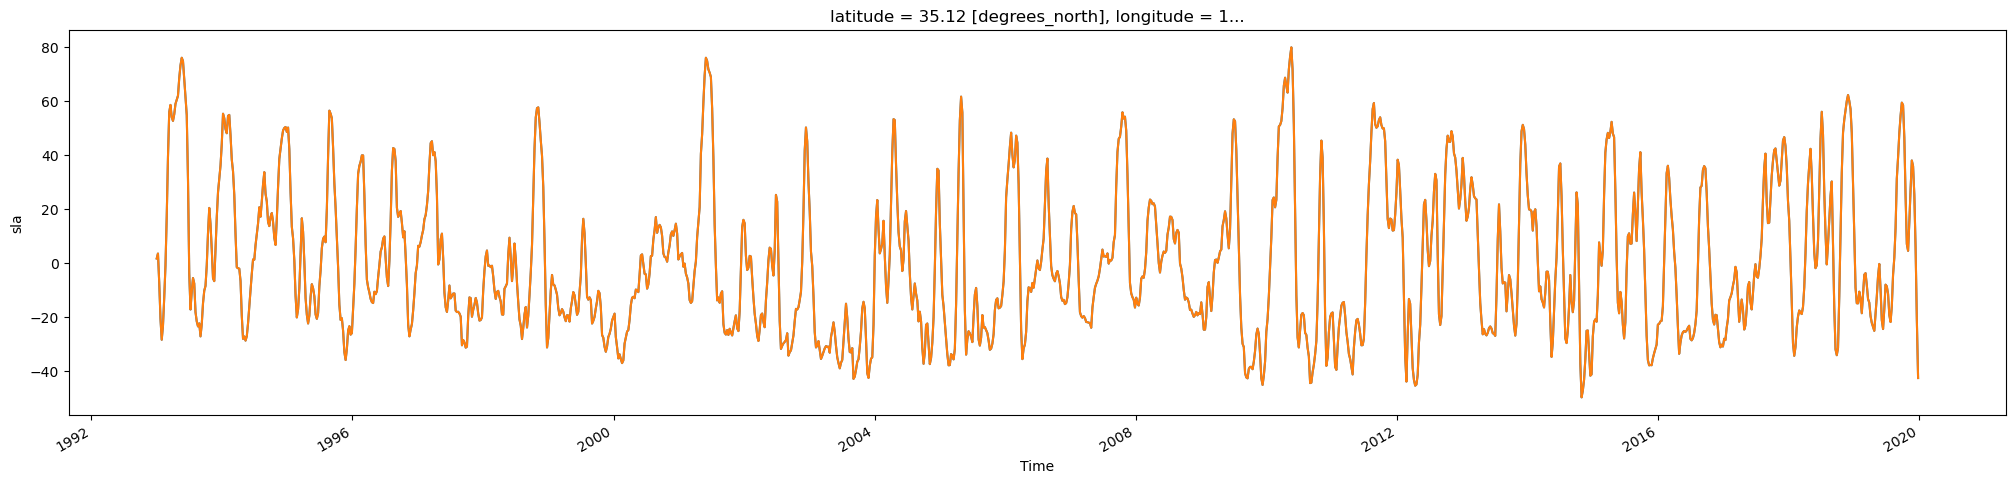

In [34]:
#Se comprueba que queda igual que en el ejemplo.

fig, ax = plt.subplots(figsize=(25, 5))
ej_anom_month.plot()
data_dt_month.sel(latitude=35, longitude=160, method='nearest').plot()
print(ej_anom_month - data_dt_month.sel(latitude=35, longitude=160, method='nearest'))

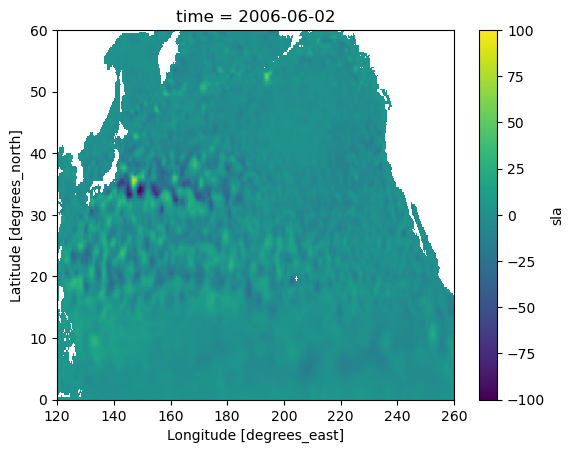

In [35]:
#Representa la anomalía para ver si tiene sentido.

data_dt_month[700,:,:].plot(vmin=-100, vmax=100)

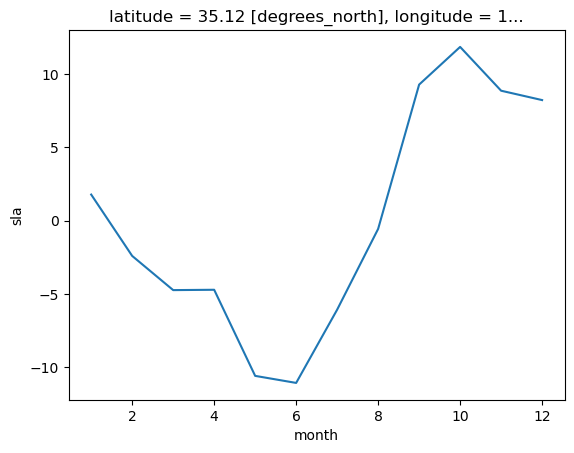

In [36]:
#Se representa el ciclo estacional agrupando por meses.
#El dayofyear está mal a partir de marzo.

climm = ej_ten.groupby('time.month').mean(dim='time')
#climd = ej_ten.groupby('time.dayofyear').mean(dim='time')


#fig, ax = plt.subplots(figsize=(25, 10))
#plt.figure(1)
#plt.plot(climd, 'o')
#plt.figure(2)
climm.plot()

In [37]:
#Se definen las 10 áreas como las del artículo de Kobashi.
#Las p son datos sin quitar el ciclo estacional.

a1_lat = data_dt_month.latitude.loc[18:26]
a1_lon = data_dt_month.longitude.loc[130:150]
a1 = data_dt_month.sel(latitude=a1_lat, longitude=a1_lon)
a1p = data_dt.sel(latitude=a1_lat, longitude=a1_lon)

a2_lat = data_dt_month.latitude.loc[18:26]
a2_lon = data_dt_month.longitude.loc[150:170]
a2 = data_dt_month.sel(latitude=a2_lat, longitude=a2_lon)
a2p = data_dt.sel(latitude=a2_lat, longitude=a2_lon)

a3_lat = data_dt_month.latitude.loc[18:26]
a3_lon = data_dt_month.longitude.loc[170:190]
a3 = data_dt_month.sel(latitude=a3_lat, longitude=a3_lon)
a3p = data_dt.sel(latitude=a3_lat, longitude=a3_lon)

a4_lat = data_dt_month.latitude.loc[23:29]
a4_lon = data_dt_month.longitude.loc[190:210]
a4 = data_dt_month.sel(latitude=a4_lat, longitude=a4_lon)
a4p = data_dt.sel(latitude=a4_lat, longitude=a4_lon)

a5_lat = data_dt_month.latitude.loc[28:35]
a5_lon = data_dt_month.longitude.loc[127.5:135]
a5 = data_dt_month.sel(latitude=a5_lat, longitude=a5_lon)
a5p = data_dt.sel(latitude=a5_lat, longitude=a5_lon)

a6_lat = data_dt_month.latitude.loc[28:35]
a6_lon = data_dt_month.longitude.loc[135:142.5]
a6 = data_dt_month.sel(latitude=a6_lat, longitude=a6_lon)
a6p = data_dt.sel(latitude=a6_lat, longitude=a6_lon)

a7_lat = data_dt_month.latitude.loc[32:37]
a7_lon = data_dt_month.longitude.loc[142.5:160]
a7 = data_dt_month.sel(latitude=a7_lat, longitude=a7_lon)
a7p = data_dt.sel(latitude=a7_lat, longitude=a7_lon)

a8_lat = data_dt_month.latitude.loc[32:37]
a8_lon = data_dt_month.longitude.loc[160:177.5]
a8 = data_dt_month.sel(latitude=a8_lat, longitude=a8_lon)
a8p = data_dt.sel(latitude=a8_lat, longitude=a8_lon)

a9_lat = data_dt_month.latitude.loc[9:16]
a9_lon = data_dt_month.longitude.loc[127:157]
a9 = data_dt_month.sel(latitude=a9_lat, longitude=a9_lon)
a9p = data_dt.sel(latitude=a9_lat, longitude=a9_lon)

a10_lat = data_dt_month.latitude.loc[2:8]
a10_lon = data_dt_month.longitude.loc[130:170]
a10 = data_dt_month.sel(latitude=a10_lat, longitude=a10_lon)
a10p = data_dt.sel(latitude=a10_lat, longitude=a10_lon)

"""
fig, ax = plt.subplots(figsize=(20,8))
ax.contourf(data_dt_month.longitude, data_dt_month.latitude, data_dt_month[700])
ax.contourf(a1_lon, a1_lat, a1[700], cmap='plasma')
ax.contourf(a2_lon, a2_lat, a2[700], cmap='Greys')
ax.contourf(a3_lon, a3_lat, a3[700], cmap='Blues')
ax.contourf(a4_lon, a4_lat, a4[700], cmap='jet')
ax.contourf(a5_lon, a5_lat, a5[700], cmap='Greys')
ax.contourf(a6_lon, a6_lat, a6[700], cmap='jet')
ax.contourf(a7_lon, a7_lat, a7[700], cmap='plasma')
ax.contourf(a8_lon, a8_lat, a8[700], cmap='Purples')
ax.contourf(a9_lon, a9_lat, a9[700], cmap='magma')
ax.contourf(a10_lon, a10_lat, a10[700], cmap='Blues')

plt.show()
"""

"\nfig, ax = plt.subplots(figsize=(20,8))\nax.contourf(data_dt_month.longitude, data_dt_month.latitude, data_dt_month[700])\nax.contourf(a1_lon, a1_lat, a1[700], cmap='plasma')\nax.contourf(a2_lon, a2_lat, a2[700], cmap='Greys')\nax.contourf(a3_lon, a3_lat, a3[700], cmap='Blues')\nax.contourf(a4_lon, a4_lat, a4[700], cmap='jet')\nax.contourf(a5_lon, a5_lat, a5[700], cmap='Greys')\nax.contourf(a6_lon, a6_lat, a6[700], cmap='jet')\nax.contourf(a7_lon, a7_lat, a7[700], cmap='plasma')\nax.contourf(a8_lon, a8_lat, a8[700], cmap='Purples')\nax.contourf(a9_lon, a9_lat, a9[700], cmap='magma')\nax.contourf(a10_lon, a10_lat, a10[700], cmap='Blues')\n\nplt.show()\n"

/Users/pvb/miniconda3/envs/DataAnalisis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


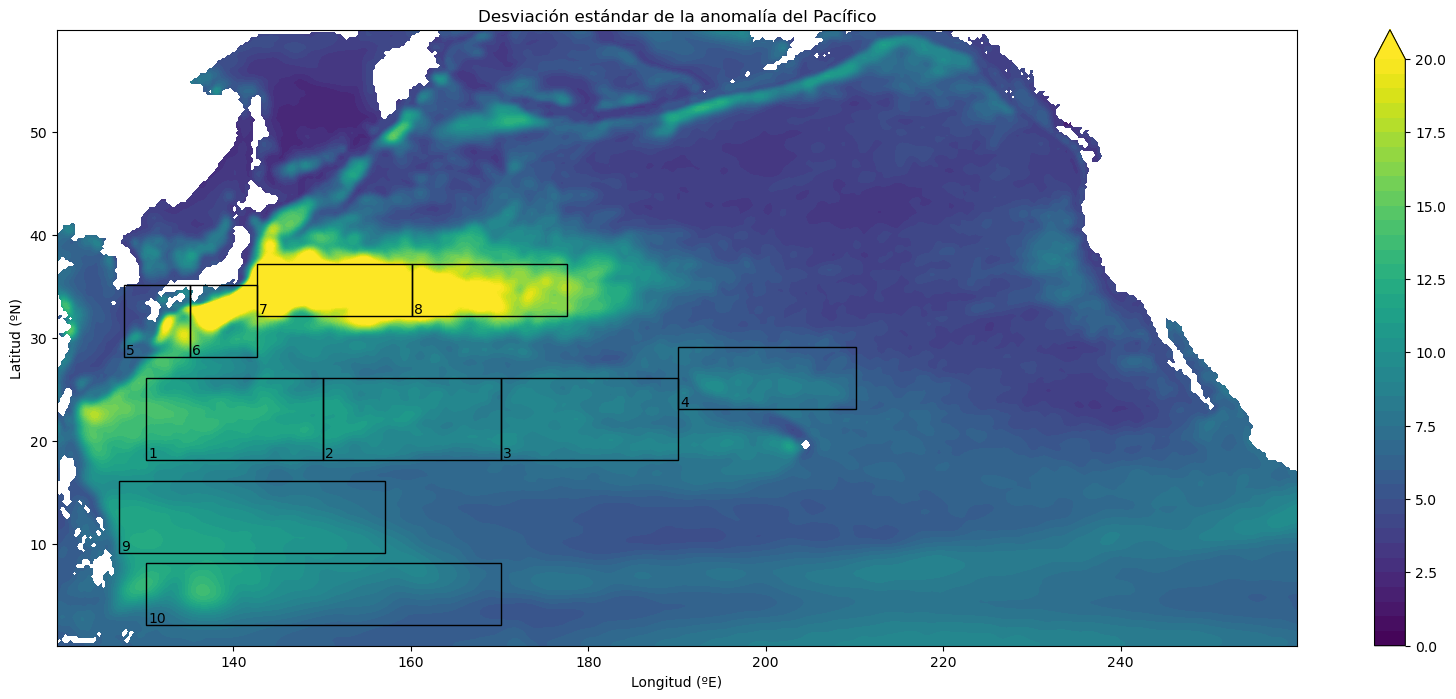

In [38]:
#Se representar las 10 áreas sobre la desviación estándar.

fig, ax = plt.subplots(figsize=(20,8))
levels = np.linspace(0, 20, 41)
A = ax.contourf(data_dt_month.longitude, data_dt_month.latitude, data_dt_month.std(dim='time'), 
                levels=levels, extend='max')
fig.colorbar(A)

#ax.contourf(data_dt_month.longitude, data_dt_month.latitude, data_dt_month.std(dim='time'), levels=[0.0799, 0.08], colors='red')

ax.add_patch(mtp.Rectangle((a1_lon[0],a1_lat[0]), len(a1_lon)*0.25, len(a1_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a1_lon[1],a1_lat[1], '1')
ax.add_patch(mtp.Rectangle((a2_lon[0],a2_lat[0]), len(a2_lon)*0.25, len(a2_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a2_lon[1],a2_lat[1], '2')
ax.add_patch(mtp.Rectangle((a3_lon[0],a3_lat[0]), len(a3_lon)*0.25, len(a3_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a3_lon[1],a3_lat[1], '3')
ax.add_patch(mtp.Rectangle((a4_lon[0],a4_lat[0]), len(a4_lon)*0.25, len(a4_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a4_lon[1],a4_lat[1], '4')
ax.add_patch(mtp.Rectangle((a5_lon[0],a5_lat[0]), len(a5_lon)*0.25, len(a5_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a5_lon[1],a5_lat[1], '5')
ax.add_patch(mtp.Rectangle((a6_lon[0],a6_lat[0]), len(a6_lon)*0.25, len(a6_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a6_lon[1],a6_lat[1], '6')
ax.add_patch(mtp.Rectangle((a7_lon[0],a7_lat[0]), len(a7_lon)*0.25, len(a7_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a7_lon[1],a7_lat[1], '7')
ax.add_patch(mtp.Rectangle((a8_lon[0],a8_lat[0]), len(a8_lon)*0.25, len(a8_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a8_lon[1],a8_lat[1], '8')
ax.add_patch(mtp.Rectangle((a9_lon[0],a9_lat[0]), len(a9_lon)*0.25, len(a9_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a9_lon[1],a9_lat[1], '9')
ax.add_patch(mtp.Rectangle((a10_lon[0],a10_lat[0]), len(a10_lon)*0.25, len(a10_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a10_lon[1],a10_lat[1], '10')

ax.set_title('Desviación estándar de la anomalía del Pacífico')
ax.set_xlabel('Longitud (ºE)')
ax.set_ylabel('Latitud (ºN)')


plt.show()

In [39]:
#Análisis espectral de las 10 áreas con las funciones de la universidad de Hawaii.

freqs1, ps1, psd1 = spectrum4(a1.values, dt=7)
freqs2, ps2, psd2 = spectrum4(a2.values, dt=7)
freqs3, ps3, psd3 = spectrum4(a3.values, dt=7)
freqs4, ps4, psd4 = spectrum4(a4.values, dt=7)
freqs5, ps5, psd5 = spectrum4(a5.values, dt=7)
freqs6, ps6, psd6 = spectrum4(a6.values, dt=7)
freqs7, ps7, psd7 = spectrum4(a7.values, dt=7)
freqs8, ps8, psd8 = spectrum4(a8.values, dt=7)
freqs9, ps9, psd9 = spectrum4(a9.values, dt=7)
freqs10, ps10, psd10 = spectrum4(a10.values, dt=7)

In [40]:
#Sin quitar ciclo estacional.

freqs1p, ps1p, psd1p = spectrum4(a1p.values, dt=7)
freqs2p, ps2p, psd2p = spectrum4(a2p.values, dt=7)
freqs3p, ps3p, psd3p = spectrum4(a3p.values, dt=7)
freqs4p, ps4p, psd4p = spectrum4(a4p.values, dt=7)
freqs5p, ps5p, psd5p = spectrum4(a5p.values, dt=7)
freqs6p, ps6p, psd6p = spectrum4(a6p.values, dt=7)
freqs7p, ps7p, psd7p = spectrum4(a7p.values, dt=7)
freqs8p, ps8p, psd8p = spectrum4(a8p.values, dt=7)
freqs9p, ps9p, psd9p = spectrum4(a9p.values, dt=7)
freqs10p, ps10p, psd10p = spectrum4(a10p.values, dt=7)

In [41]:
#Con la función spectrum1.

freqs1r, ps1r, psd1r = spectrum1(a1.values, dt=7)
freqs2r, ps2r, psd2r = spectrum1(a2.values, dt=7)
freqs3r, ps3r, psd3r = spectrum1(a3.values, dt=7)
freqs4r, ps4r, psd4r = spectrum1(a4.values, dt=7)
freqs5r, ps5r, psd5r = spectrum1(a5.values, dt=7)
freqs6r, ps6r, psd6r = spectrum1(a6.values, dt=7)
freqs7r, ps7r, psd7r = spectrum1(a7.values, dt=7)
freqs8r, ps8r, psd8r = spectrum1(a8.values, dt=7)
freqs9r, ps9r, psd9r = spectrum1(a9.values, dt=7)
freqs10r, ps10r, psd10r = spectrum1(a10.values, dt=7)

In [42]:
#Media de todos los puntos de cada área. Nanmean para las áeras que tienen zonas sin datos (porque es tierra).

media1 = np.mean(np.mean(psd1, axis=1), axis=1)
media2 = np.mean(np.mean(psd2, axis=1), axis=1)
media3 = np.mean(np.mean(psd3, axis=1), axis=1)
media4 = np.mean(np.mean(psd4, axis=1), axis=1)
media5 = np.nanmean(np.nanmean(psd5, axis=1), axis=1)
media6 = np.nanmean(np.nanmean(psd6, axis=1), axis=1)
media7 = np.mean(np.mean(psd7, axis=1), axis=1)
media8 = np.mean(np.mean(psd8, axis=1), axis=1)
media9 = np.mean(np.mean(psd9, axis=1), axis=1)
media10 = np.mean(np.mean(psd10, axis=1), axis=1)

In [43]:
#Sin quitar ciclo estacional.

media1p = np.mean(np.mean(psd1p, axis=1), axis=1)
media2p = np.mean(np.mean(psd2p, axis=1), axis=1)
media3p = np.mean(np.mean(psd3p, axis=1), axis=1)
media4p = np.mean(np.mean(psd4p, axis=1), axis=1)
media5p = np.nanmean(np.nanmean(psd5p, axis=1), axis=1)
media6p = np.nanmean(np.nanmean(psd6p, axis=1), axis=1)
media7p = np.mean(np.mean(psd7p, axis=1), axis=1)
media8p = np.mean(np.mean(psd8p, axis=1), axis=1)
media9p = np.mean(np.mean(psd9p, axis=1), axis=1)
media10p = np.mean(np.mean(psd10p, axis=1), axis=1)

In [44]:
#Con la función spectrum1.

media1r = np.mean(np.mean(psd1r, axis=1), axis=1)
media2r = np.mean(np.mean(psd2r, axis=1), axis=1)
media3r = np.mean(np.mean(psd3r, axis=1), axis=1)
media4r = np.mean(np.mean(psd4r, axis=1), axis=1)
media5r = np.nanmean(np.nanmean(psd5r, axis=1), axis=1)
media6r = np.nanmean(np.nanmean(psd6r, axis=1), axis=1)
media7r = np.mean(np.mean(psd7r, axis=1), axis=1)
media8r = np.mean(np.mean(psd8r, axis=1), axis=1)
media9r = np.mean(np.mean(psd9r, axis=1), axis=1)
media10r = np.mean(np.mean(psd10r, axis=1), axis=1)

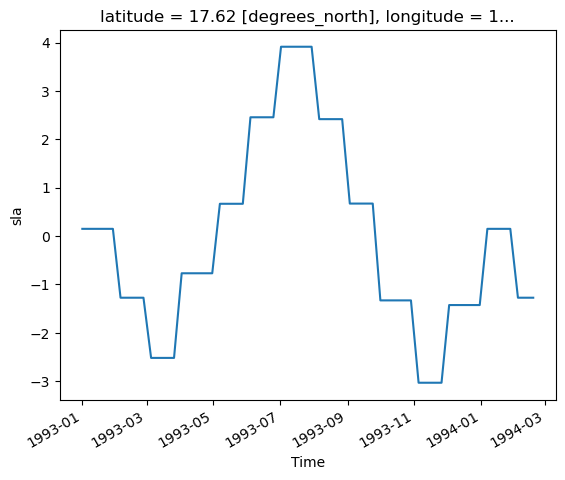

In [45]:
#Ciclo estacional.

data_clim = data_dt - data_dt_month

data_clim[:60, 70, 140].plot()

In [46]:
#Climatología del área 1.

a1_clim = data_clim.sel(latitude=a1_lat, longitude=a1_lon)

freqs1_clim, ps1_clim, psd1_clim = spectrum4(a1_clim.values, dt=7)
media1_clim = np.mean(np.mean(psd1_clim, axis=1), axis=1)

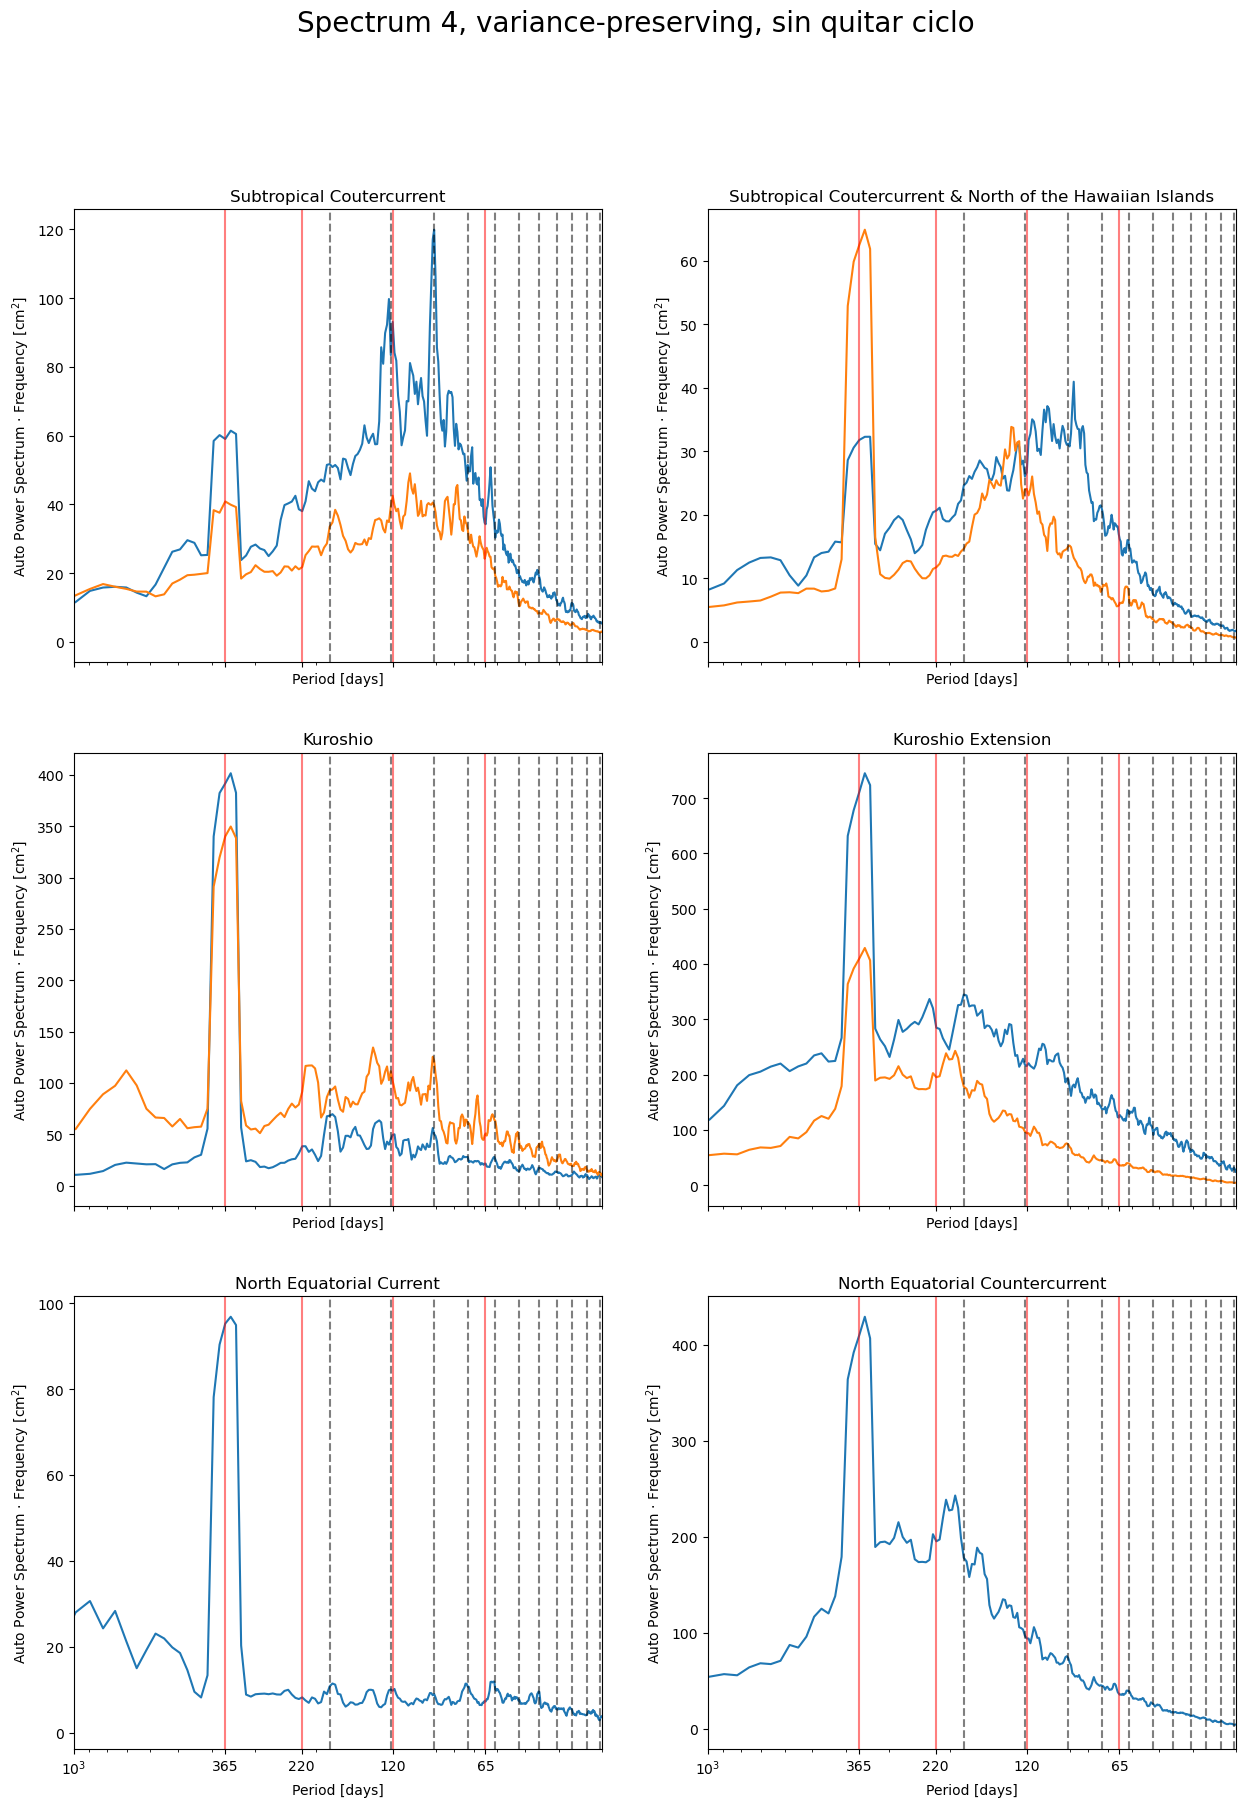

In [47]:
#Representaciones como las del artículo de Kobashi.
#Utilizando Spectrum 4, con variance-preserving y con el ciclo estacional.
#Las líneas rojas corresponden a 365, 220, 120 y 65 días.
#Las líneas grises a trazos corresponden a los armónicos del ciclo estacional (365/2, 365/3, ... , 365/12).

fig, ax = plt.subplots(3,2 , figsize=(15,20), sharex=True)
plt.xlim(1000, 30)
fig.suptitle('Spectrum 4, variance-preserving, sin quitar ciclo', fontsize=20)

ax[0, 0].set_title('Subtropical Coutercurrent')
ax[0, 0].semilogx((1/freqs1p)[::-1], media1p[::-1]*freqs1p[::-1])
ax[0, 0].semilogx((1/freqs2p)[::-1], media2p[::-1]*freqs2p[::-1])
#ax[0, 0].set(ylim=(0,2))

ax[0, 1].set_title('Subtropical Coutercurrent & North of the Hawaiian Islands')
ax[0, 1].semilogx((1/freqs3p)[::-1], media3p[::-1]*freqs3p[::-1])
ax[0, 1].semilogx((1/freqs4p)[::-1], media4p[::-1]*freqs4p[::-1])
#ax[0, 1].set(ylim=(0,1))

ax[1, 0].set_title('Kuroshio')
ax[1, 0].semilogx((1/freqs5p)[::-1], media5p[::-1]*freqs5p[::-1])
ax[1, 0].semilogx((1/freqs6p)[::-1], media6p[::-1]*freqs6p[::-1])
#ax[1, 0].set(ylim=(0,15))

ax[1, 1].set_title('Kuroshio Extension')
ax[1, 1].semilogx((1/freqs7p)[::-1], media7p[::-1]*freqs7p[::-1])
ax[1, 1].semilogx((1/freqs8p)[::-1], media8p[::-1]*freqs8p[::-1])
#ax[1, 1].set(ylim=(0, 20))

ax[2, 0].set_title('North Equatorial Current')
ax[2, 0].semilogx((1/freqs9p)[::-1], media9p[::-1]*freqs9p[::-1])
#ax[2, 0].set(ylim=(0,4))

ax[2, 1].set_title('North Equatorial Countercurrent')
ax[2, 1].semilogx((1/freqs10p)[::-1], media8p[::-1]*freqs10p[::-1])
#ax[2, 1].set(ylim=(0,10))

plt.xticks([ 65, 120, 220, 365, 1000], [ '65', '120', '220', '365', '$10^3$'])

for ax in ax.flat:
  ax.axvline(365, ls='-', color='r', alpha=0.5)
  ax.axvline(182.5, ls='--', color='k', alpha=0.5)
  ax.axvline(121.7, ls='--', color='k', alpha=0.5)
  ax.axvline(91.25, ls='--', color='k', alpha=0.5)
  ax.axvline(73, ls='--', color='k', alpha=0.5)
  ax.axvline(60.83, ls='--', color='k', alpha=0.5)
  ax.axvline(52.15, ls='--', color='k', alpha=0.5)
  ax.axvline(45.625, ls='--', color='k', alpha=0.5)
  ax.axvline(40.55, ls='--', color='k', alpha=0.5)
  ax.axvline(36.5, ls='--', color='k', alpha=0.5)
  ax.axvline(33.18, ls='--', color='k', alpha=0.5)
  ax.axvline(30.41, ls='--', color='k', alpha=0.5)
  ax.axvline(28.07, ls='--', color='k', alpha=0.5)
  ax.axvline(220, ls='-', color='r', alpha=0.5)
  ax.axvline(120, ls='-', color='r', alpha=0.5)
  ax.axvline(65, ls='-', color='r', alpha=0.5)
  ax.set(xlabel='Period [days]')
  ax.set(ylabel='Auto Power Spectrum $\cdot$ Frequency [cm$^2$]')

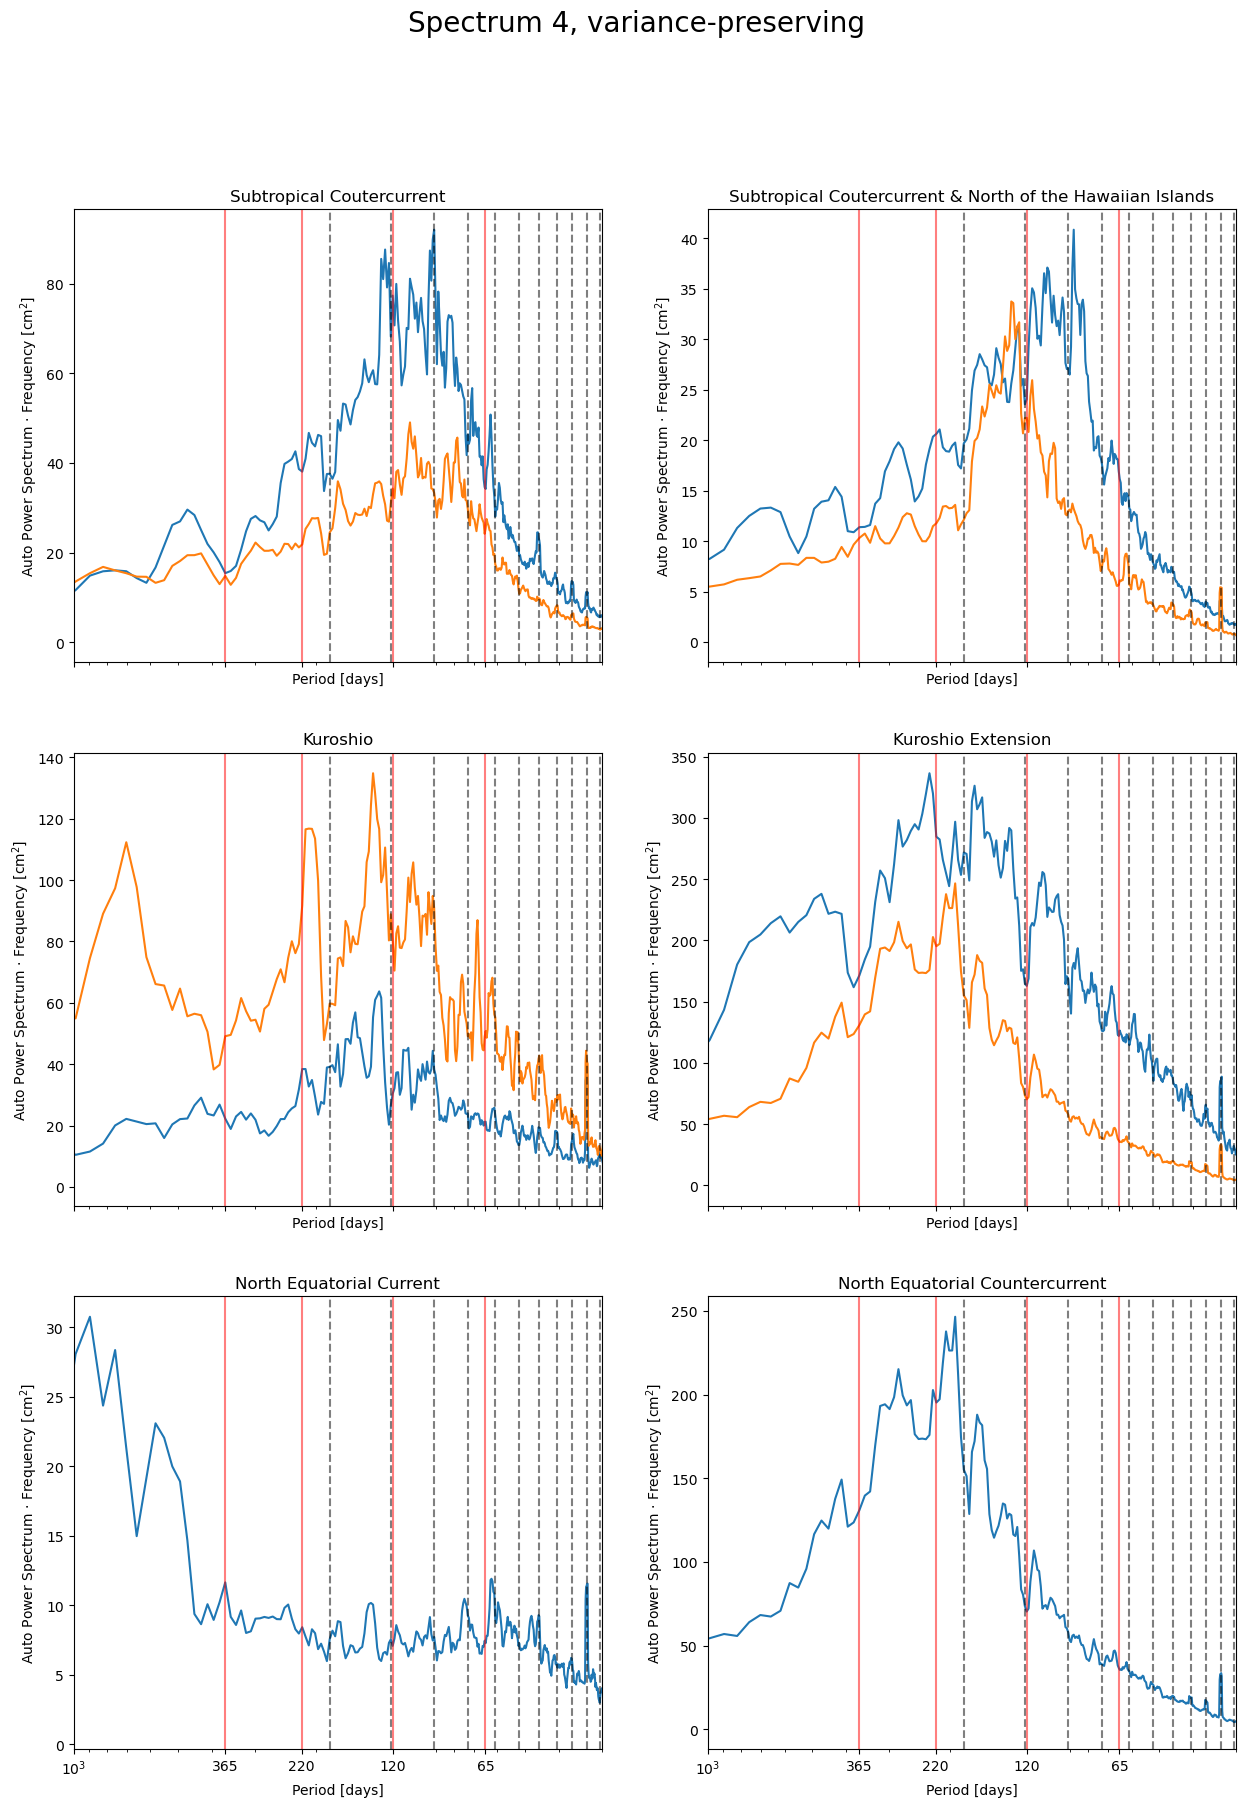

In [48]:
#En este caso sin ciclo estacional.

fig, ax = plt.subplots(3,2 , figsize=(15,20), sharex=True)
plt.xlim(1000, 30)
fig.suptitle('Spectrum 4, variance-preserving', fontsize=20)

ax[0, 0].set_title('Subtropical Coutercurrent')
ax[0, 0].semilogx((1/freqs1)[::-1], media1[::-1]*freqs1[::-1])
ax[0, 0].semilogx((1/freqs2)[::-1], media2[::-1]*freqs2[::-1])

ax[0, 1].set_title('Subtropical Coutercurrent & North of the Hawaiian Islands')
ax[0, 1].semilogx((1/freqs3)[::-1], media3[::-1]*freqs3[::-1])
ax[0, 1].semilogx((1/freqs4)[::-1], media4[::-1]*freqs4[::-1])

ax[1, 0].set_title('Kuroshio')
ax[1, 0].semilogx((1/freqs5)[::-1], media5[::-1]*freqs5[::-1])
ax[1, 0].semilogx((1/freqs6)[::-1], media6[::-1]*freqs6[::-1])

ax[1, 1].set_title('Kuroshio Extension')
ax[1, 1].semilogx((1/freqs7)[::-1], media7[::-1]*freqs7[::-1])
ax[1, 1].semilogx((1/freqs8)[::-1], media8[::-1]*freqs8[::-1])

ax[2, 0].set_title('North Equatorial Current')
ax[2, 0].semilogx((1/freqs9)[::-1], media9[::-1]*freqs9[::-1])

ax[2, 1].set_title('North Equatorial Countercurrent')
ax[2, 1].semilogx((1/freqs10)[::-1], media8[::-1]*freqs10[::-1])

plt.xticks([65, 120, 220, 365, 1000], ['65', '120', '220', '365', '$10^3$'])

for ax in ax.flat:
  ax.axvline(365, ls='-', color='r', alpha=0.5)
  ax.axvline(182.5, ls='--', color='k', alpha=0.5)
  ax.axvline(121.7, ls='--', color='k', alpha=0.5)
  ax.axvline(91.25, ls='--', color='k', alpha=0.5)
  ax.axvline(73, ls='--', color='k', alpha=0.5)
  ax.axvline(60.83, ls='--', color='k', alpha=0.5)
  ax.axvline(52.15, ls='--', color='k', alpha=0.5)
  ax.axvline(45.625, ls='--', color='k', alpha=0.5)
  ax.axvline(40.55, ls='--', color='k', alpha=0.5)
  ax.axvline(36.5, ls='--', color='k', alpha=0.5)
  ax.axvline(33.18, ls='--', color='k', alpha=0.5)
  ax.axvline(30.41, ls='--', color='k', alpha=0.5)
  ax.axvline(28.07, ls='--', color='k', alpha=0.5)
  ax.axvline(220, ls='-', color='r', alpha=0.5)
  ax.axvline(120, ls='-', color='r', alpha=0.5)
  ax.axvline(65, ls='-', color='r', alpha=0.5)
  ax.set(xlabel='Period [days]')
  ax.set(ylabel='Auto Power Spectrum $\cdot$ Frequency [cm$^2$]')

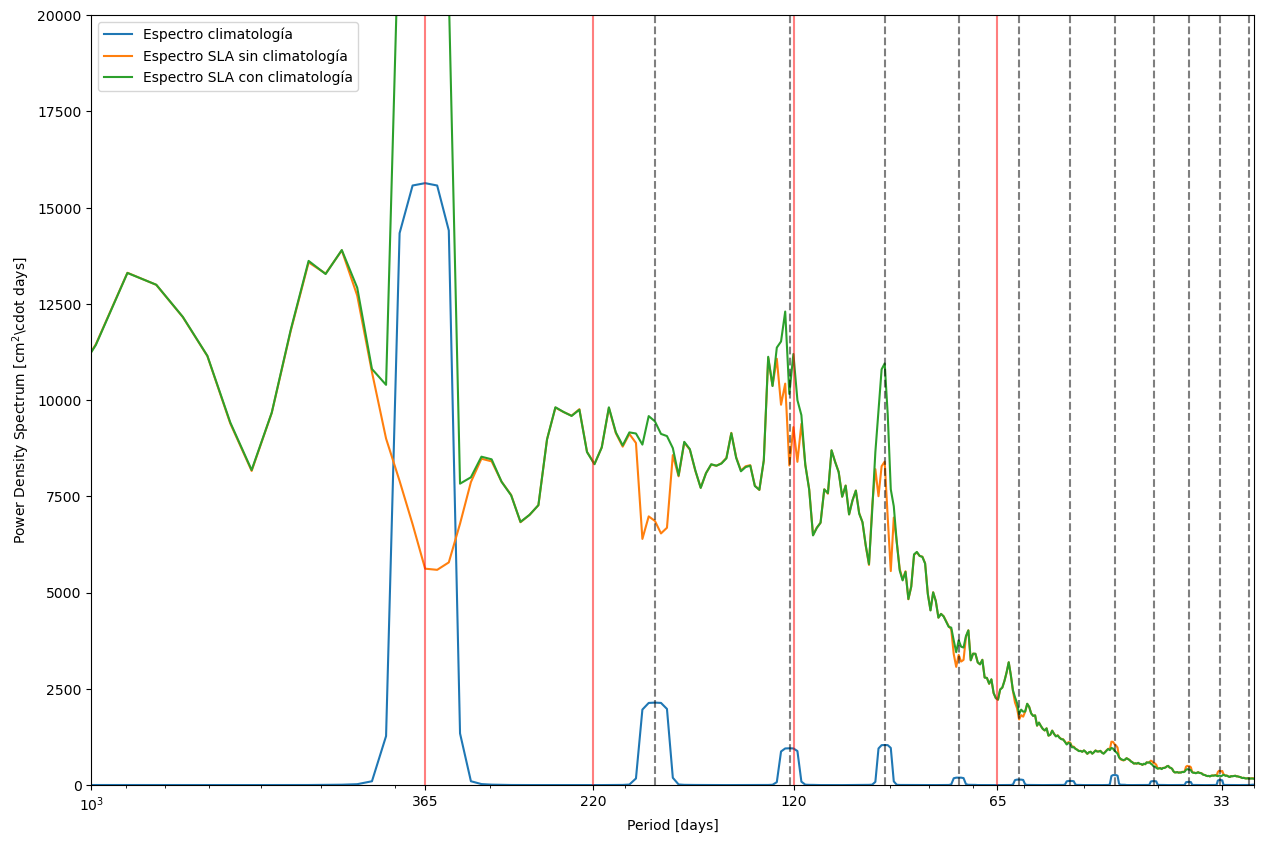

In [49]:
#Comparación de los espectros de la climatología, del SLA con climatología y sin ella del área 1.
#Sin variance-preserving.

fig, ax = plt.subplots(figsize=(15,10))
plt.xlim(500, 30)
plt.ylim(0, 20000)

ax.semilogx((1/freqs1_clim)[::-1], media1_clim[::-1])
ax.semilogx((1/freqs1)[::-1], media1[::-1])
ax.semilogx((1/freqs1p)[::-1], media1p[::-1])

ax.legend(('Espectro climatología', 'Espectro SLA sin climatología', 'Espectro SLA con climatología'))
ax.axvline(365, ls='-', color='r', alpha=0.5)
ax.axvline(182.5, ls='--', color='k', alpha=0.5)
ax.axvline(121.7, ls='--', color='k', alpha=0.5)
ax.axvline(91.25, ls='--', color='k', alpha=0.5)
ax.axvline(73, ls='--', color='k', alpha=0.5)
ax.axvline(60.83, ls='--', color='k', alpha=0.5)
ax.axvline(52.15, ls='--', color='k', alpha=0.5)
ax.axvline(45.625, ls='--', color='k', alpha=0.5)
ax.axvline(40.55, ls='--', color='k', alpha=0.5)
ax.axvline(36.5, ls='--', color='k', alpha=0.5)
ax.axvline(33.18, ls='--', color='k', alpha=0.5)
ax.axvline(30.41, ls='--', color='k', alpha=0.5)
ax.axvline(28.07, ls='--', color='k', alpha=0.5)
ax.axvline(220, ls='-', color='r', alpha=0.5)
ax.axvline(120, ls='-', color='r', alpha=0.5)
ax.axvline(65, ls='-', color='r', alpha=0.5)
ax.set(xlabel='Period [days]')
ax.set(ylabel='Power Density Spectrum [cm$^2$\cdot days]')

plt.xticks([33, 65, 120, 220, 365, 1000], ['33', '65', '120', '220', '365', '$10^3$'])

plt.show()

In [50]:
#Integral del PSD entre 65 y 220 sobre todo el pacífico.

inte = np.zeros([psd_t.shape[1],psd_t.shape[2]])

for i in range(psd_t.shape[1]):
  for j in range(psd_t.shape[2]):
    inte[i,j] = np.trapz(psd_t[44:-552,i,j], freqs_t[44:-552])

/Users/pvb/miniconda3/envs/DataAnalisis/lib/python3.11/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


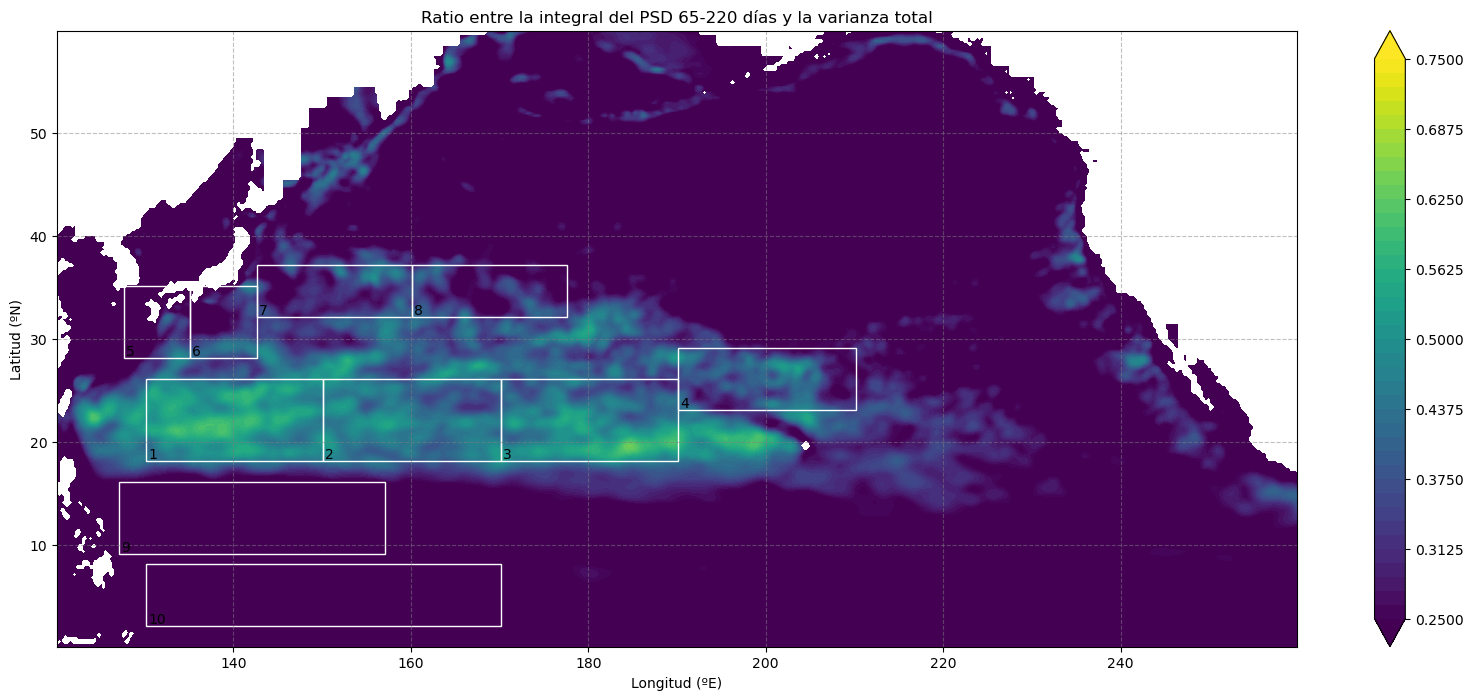

In [51]:
#Representación del ratio 65-220 días y varianza total.

fig, ax = plt.subplots(figsize=(20,8))
levels = np.linspace(0.25, 0.75, 41)
B = ax.contourf(data_dt_month.longitude, data_dt_month.latitude, inte / data_dt.var(dim='time'), 
                levels=levels, extend='both')
fig.colorbar(B)

#ax.contourf(data_dt_month.longitude, data_dt_month.latitude, data_dt_month.std(dim='time'), levels=[0.0799, 0.08], colors='red')

ax.add_patch(mtp.Rectangle((a1_lon[0],a1_lat[0]), len(a1_lon)*0.25, len(a1_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a1_lon[1],a1_lat[1], '1')
ax.add_patch(mtp.Rectangle((a2_lon[0],a2_lat[0]), len(a2_lon)*0.25, len(a2_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a2_lon[1],a2_lat[1], '2')
ax.add_patch(mtp.Rectangle((a3_lon[0],a3_lat[0]), len(a3_lon)*0.25, len(a3_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a3_lon[1],a3_lat[1], '3')
ax.add_patch(mtp.Rectangle((a4_lon[0],a4_lat[0]), len(a4_lon)*0.25, len(a4_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a4_lon[1],a4_lat[1], '4')
ax.add_patch(mtp.Rectangle((a5_lon[0],a5_lat[0]), len(a5_lon)*0.25, len(a5_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a5_lon[1],a5_lat[1], '5')
ax.add_patch(mtp.Rectangle((a6_lon[0],a6_lat[0]), len(a6_lon)*0.25, len(a6_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a6_lon[1],a6_lat[1], '6')
ax.add_patch(mtp.Rectangle((a7_lon[0],a7_lat[0]), len(a7_lon)*0.25, len(a7_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a7_lon[1],a7_lat[1], '7')
ax.add_patch(mtp.Rectangle((a8_lon[0],a8_lat[0]), len(a8_lon)*0.25, len(a8_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a8_lon[1],a8_lat[1], '8')
ax.add_patch(mtp.Rectangle((a9_lon[0],a9_lat[0]), len(a9_lon)*0.25, len(a9_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a9_lon[1],a9_lat[1], '9')
ax.add_patch(mtp.Rectangle((a10_lon[0],a10_lat[0]), len(a10_lon)*0.25, len(a10_lat)*0.25, edgecolor = 'white', fill=False))
ax.text(a10_lon[1],a10_lat[1], '10')

ax.set_title('Ratio entre la integral del PSD 65-220 días y la varianza total')
ax.set_xlabel('Longitud (ºE)')
ax.set_ylabel('Latitud (ºN)')

ax.xaxis.grid(True, zorder=0, color='grey', linestyle='--', alpha=0.5)
ax.yaxis.grid(True, zorder=0, color='grey', linestyle='--', alpha=0.5)

plt.show()

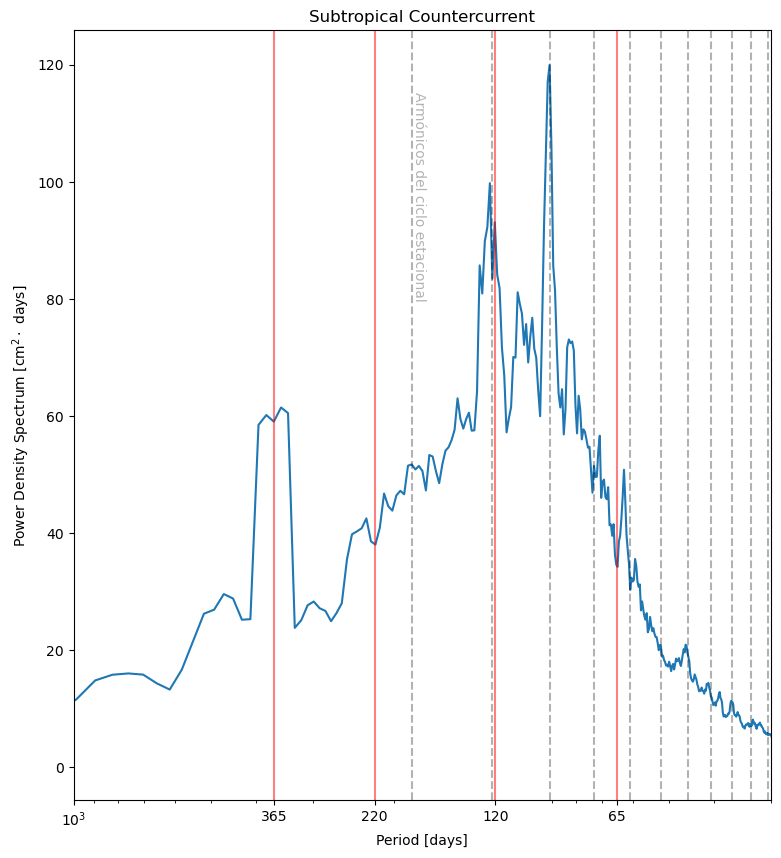

In [52]:
fig, ax = plt.subplots(figsize=(9, 10))
plt.xlim(1000, 30)

ax.semilogx((1/freqs1p)[::-1], media1p[::-1]*freqs1p[::-1])

plt.xticks([ 65, 120, 220, 365, 1000], [ '65', '120', '220', '365', '$10^3$'])
ax.set_title('Subtropical Countercurrent')


ax.axvline(365, ls='-', color='r', alpha=0.5)
ax.axvline(182.5, ls='--', color='k', alpha=0.3)
ax.axvline(121.7, ls='--', color='k', alpha=0.3)
ax.axvline(91.25, ls='--', color='k', alpha=0.3)
ax.axvline(73, ls='--', color='k', alpha=0.3)
ax.axvline(60.83, ls='--', color='k', alpha=0.3)
ax.axvline(52.15, ls='--', color='k', alpha=0.3)
ax.axvline(45.625, ls='--', color='k', alpha=0.3)
ax.axvline(40.55, ls='--', color='k', alpha=0.3)
ax.axvline(36.5, ls='--', color='k', alpha=0.3)
ax.axvline(33.18, ls='--', color='k', alpha=0.3)
ax.axvline(30.41, ls='--', color='k', alpha=0.3)
ax.axvline(28.07, ls='--', color='k', alpha=0.3)
ax.axvline(220, ls='-', color='r', alpha=0.5)
ax.axvline(120, ls='-', color='r', alpha=0.5)
ax.axvline(65, ls='-', color='r', alpha=0.5)
ax.set(xlabel='Period [days]')
ax.set(ylabel='Power Density Spectrum [cm$^2\cdot$ days]')

ax.text(182.4, 80,'Armónicos del ciclo estacional',rotation=270, alpha=0.3)

plt.show()